Super Resolution Min Sample x4 resolution

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape,MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam


In [10]:
img_rows = 40
img_cols = 40
channels = 3

img_shape = (img_rows, img_cols, channels)

## Build the Model

In [11]:
#generate the model with tranposed convolution layer with stride value 2 will make the image size double in both x and y
def build_super_res(img_shape):
    model = Sequential()
    model.add(Conv2DTranspose(128, kernel_size=5, strides=1, padding='same',input_shape=img_shape, kernel_initializer='lecun_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', kernel_initializer='lecun_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(3, kernel_size=3, strides=1, padding='same' , kernel_initializer='lecun_uniform'))
    model.add(Activation('tanh'))
    return model

In [12]:
# Build and compile the superRez
superz = build_super_res(img_shape)
optimizer=Adam()
superz.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['accuracy'])
saver = tf.train.Saver(name="saver")
checkpoint_directory = "models"
checkpoint_prefix = os.path.join(checkpoint_directory, "model.ckpt")
print(checkpoint_prefix)

models\model.ckpt


In [13]:
superz.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_3 (Conv2DTr (None, 40, 40, 128)       9728      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 40, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 80, 80, 128)       409728    
_________________________________________________________________
batch_normalization_3 (Batch (None, 80, 80, 128)       512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 80, 80, 128)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 80, 80, 3)         3459      
__________

## Training

In [14]:
boxsize = 80
# to test our network we will use small images croped from larger pictures, with width and height equal to boxsize for x4 super 
# resolution we use 80x80 images and for x16 super resolution we use 160x160 images
def getSmalerImages(img):
    originals=[]
    resizeds=[]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cur_x=0
    cur_y=0
    comp = False
    while True:
        if comp:
            break
        while True:
            originals.append(img[cur_y:cur_y+boxsize,cur_x:cur_x+boxsize])
            cur_x += boxsize
            if cur_x + boxsize > img.shape[1]:
                cur_x = 0
                cur_y += boxsize
                if cur_y +boxsize > img.shape[0]:
                    comp = True
                break   
# after dividing to smaller images 
    for item in originals:
        dim = (40, 40)
        resized =  cv2.resize(item, dim, interpolation =cv2.INTER_AREA)
        resizeds.append(resized)
    return originals,resizeds


In [140]:
def buildLargeImage(fragments, horizontalcount,verticalcount):
    rows = []
    pointer = 0
    for i in range(verticalcount):
        row = cv2.hconcat(fragments[pointer:pointer+horizontalcount])
        pointer += horizontalcount
        rows.append(row)
    result = cv2.vconcat(rows)
    plt.imshow(result)
    plt.show()
    return result

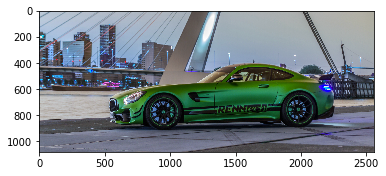

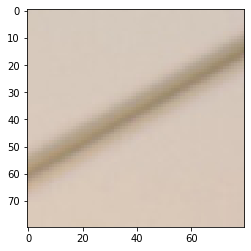

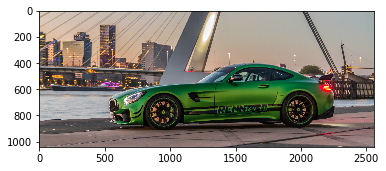

In [141]:
img = cv2.imread('cars/1.jpg')
plt.imshow(img)
plt.show()
cv2.imwrite("generatedImages/car2.jpg", img );
originals,resizeds = getSmalerImages(img)

plt.imshow(originals[0])
plt.show()
x= buildLargeImage(originals,32,13)
cv2.imwrite("generatedImages/car1.jpg", x );

In [142]:

def initMovie():
    home = os.path.expanduser("~")
    x = os.path.join(home, "Documents","Blade.Runner.2049.mkv")
    my_file = Path(x)
    if not my_file.is_file():
        print('file does not exists')
    cap = cv2.VideoCapture(x)
    return cap

def readFrame(cap):
    while True:
        ret, frame = cap.read()  
        if ret:      
            hi,low = getSmalerImages(frame)
            return hi,low    
lowRes = []
hiRes = []
def readMovie(noOfImages,cap):
    global lowRes
    global hiRes
    if len(lowRes) < noOfImages:
        hi,lo = readFrame(cap)
        hiRes.extend(hi)
        lowRes.extend(lo)
    reslo = lowRes[:noOfImages]
    reshi = hiRes[:noOfImages]
    lowRes = lowRes[noOfImages:]
    hiRes = hiRes[noOfImages:]
    reshi = np.asarray(reshi)
    reslo = np.asarray(reslo)
    reshi = reshi /127.5 - 1.0
    reslo = reslo /127.5 - 1.0
    return reshi,reslo
    

In [71]:
from_checkpoint = False
cap = initMovie()
def train(iterations, batch_size, sample_interval):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        if from_checkpoint == True:
            saver.restore(sess, checkpoint_prefix)
        for iteration in range(iterations):  
            hiRes,lowRes = readMovie(batch_size,cap)
            loss = superz.train_on_batch(lowRes, hiRes)
            if (iteration + 1) % sample_interval == 0:
                hiResTest,lowResTest = readMovie(10,cap)
                loss_test = superz.test_on_batch(lowResTest, hiResTest)
                saver.save(sess, checkpoint_prefix)
                print('itearation:{} loss train:{} loss test: {} '.format(iteration,loss,loss_test))

In [72]:
train(200000,100,100)

itearation:99 loss train:[0.16709036, 0.165] loss test: [0.69597673, 0.2609375] 
itearation:199 loss train:[0.16667944, 0.51515627] loss test: [0.16566835, 0.22125] 
itearation:299 loss train:[0.16243988, 0.35] loss test: [0.16268517, 0.25953126] 
itearation:399 loss train:[0.1308628, 0.23875] loss test: [0.13311715, 0.7753125] 
itearation:499 loss train:[7.68121e-06, 0.40875] loss test: [1.0612918e-06, 0.9984375] 
itearation:599 loss train:[0.0002695221, 0.41284218] loss test: [1.5000659e-06, 0.6109375] 
itearation:699 loss train:[2.800807e-06, 0.41359374] loss test: [1.7658156e-06, 0.6] 
itearation:799 loss train:[2.1559713e-06, 0.41359374] loss test: [1.6969658e-06, 0.59453124] 
itearation:899 loss train:[1.738022e-06, 0.41375] loss test: [1.5005128e-06, 0.59453124] 
itearation:999 loss train:[1.4367699e-06, 0.41390625] loss test: [1.2942031e-06, 0.5946875] 
itearation:1099 loss train:[1.2173068e-06, 0.41390625] loss test: [1.0835753e-06, 0.5946875] 
itearation:1199 loss train:[1.05

itearation:9299 loss train:[0.11716481, 0.66936404] loss test: [0.19822603, 0.17378125] 
itearation:9399 loss train:[0.018251004, 0.7241844] loss test: [0.1440607, 0.080078125] 
itearation:9499 loss train:[0.018746825, 0.58294374] loss test: [0.06328325, 0.26592186] 
itearation:9599 loss train:[0.012995656, 0.6583016] loss test: [0.0062360545, 0.01278125] 
itearation:9699 loss train:[0.018271958, 0.52395624] loss test: [0.021157535, 0.200125] 
itearation:9799 loss train:[0.026955988, 0.7484] loss test: [0.00062562124, 0.055640627] 
itearation:9899 loss train:[0.015782405, 0.5857422] loss test: [0.02330046, 0.40889063] 
itearation:9999 loss train:[0.010504319, 0.7117453] loss test: [0.007449582, 0.58307815] 
itearation:10099 loss train:[0.029081572, 0.5993594] loss test: [0.058487594, 0.80929685] 
itearation:10199 loss train:[0.02915288, 0.7944281] loss test: [0.023386287, 0.878125] 
itearation:10299 loss train:[0.01235545, 0.77127814] loss test: [0.084284194, 0.9701094] 
itearation:103

itearation:18199 loss train:[2.810263e-06, 0.7370312] loss test: [3.5622652e-06, 0.751875] 
itearation:18299 loss train:[0.0043950127, 0.30232343] loss test: [2.8149348e-06, 0.5765625] 
itearation:18399 loss train:[2.3180557e-06, 0.4025] loss test: [1.7725149e-06, 0.57734376] 
itearation:18499 loss train:[3.5702844e-06, 0.02328125] loss test: [9.404979e-06, 0.0159375] 
itearation:18599 loss train:[0.0036591154, 0.15776719] loss test: [0.0013925644, 0.3703125] 
itearation:18699 loss train:[3.7085513e-06, 0.21546875] loss test: [3.972563e-06, 0.03328125] 
itearation:18799 loss train:[0.0036265256, 0.3174125] loss test: [2.596922e-06, 0.06390625] 
itearation:18899 loss train:[3.6570834e-06, 0.57375] loss test: [2.1009923e-06, 0.24421875] 
itearation:18999 loss train:[0.0033787945, 0.31677344] loss test: [0.0038056418, 0.316875] 
itearation:19099 loss train:[0.0022710133, 0.4785453] loss test: [2.6385487e-06, 0.6] 
itearation:19199 loss train:[2.203028e-06, 0.82203126] loss test: [7.437060

itearation:27099 loss train:[0.033930246, 0.81604844] loss test: [0.034294974, 0.6283906] 
itearation:27199 loss train:[0.026382888, 0.9132094] loss test: [0.3331458, 0.5821406] 
itearation:27299 loss train:[0.026551118, 0.6900297] loss test: [0.032399192, 0.6412344] 
itearation:27399 loss train:[0.070677966, 0.8175828] loss test: [0.078628674, 0.9799219] 
itearation:27499 loss train:[0.023491593, 0.71500784] loss test: [0.06703008, 0.7048125] 
itearation:27599 loss train:[0.024898753, 0.6912828] loss test: [0.13733001, 0.53351563] 
itearation:27699 loss train:[0.022254746, 0.71497345] loss test: [0.05109142, 0.6960625] 
itearation:27799 loss train:[0.016105752, 0.72642344] loss test: [0.03438752, 0.76242185] 
itearation:27899 loss train:[0.019757316, 0.68920624] loss test: [0.023092728, 0.66340625] 
itearation:27999 loss train:[0.015925338, 0.7729656] loss test: [0.02107226, 0.81082815] 
itearation:28099 loss train:[0.01611683, 0.740175] loss test: [0.019183021, 0.6970937] 
itearation

itearation:36299 loss train:[0.018466827, 0.9177047] loss test: [0.032273564, 0.8838906] 
itearation:36399 loss train:[0.048362784, 0.8628531] loss test: [0.09659294, 0.30979687] 
itearation:36499 loss train:[0.015959278, 0.82431096] loss test: [0.05549406, 0.6177656] 
itearation:36599 loss train:[0.023348724, 0.9589391] loss test: [0.0103116585, 0.9566719] 
itearation:36699 loss train:[0.01292685, 0.9101547] loss test: [0.01266858, 0.9162969] 
itearation:36799 loss train:[0.010554819, 0.92351407] loss test: [0.01173622, 0.99421877] 
itearation:36899 loss train:[0.008593811, 0.9318125] loss test: [0.020349922, 0.9164375] 
itearation:36999 loss train:[0.012630996, 0.92963123] loss test: [0.008828551, 0.8412656] 
itearation:37099 loss train:[0.00606695, 0.9758375] loss test: [0.009543932, 0.9700937] 
itearation:37199 loss train:[0.010354336, 0.91578436] loss test: [0.01304422, 0.8807656] 
itearation:37299 loss train:[0.011998061, 0.98241407] loss test: [0.013254045, 0.97501564] 
itearati

itearation:45399 loss train:[0.016120886, 0.8843344] loss test: [0.019650746, 0.8758125] 
itearation:45499 loss train:[0.02706945, 0.8848297] loss test: [0.028688144, 0.73234373] 
itearation:45599 loss train:[0.028328555, 0.90033126] loss test: [0.030877788, 0.8039531] 
itearation:45699 loss train:[0.015992945, 0.94011563] loss test: [0.01897935, 0.8071875] 
itearation:45799 loss train:[0.01298885, 0.8339922] loss test: [0.024476344, 0.6278125] 
itearation:45899 loss train:[0.032002788, 0.73238903] loss test: [0.009601878, 0.991125] 
itearation:45999 loss train:[0.020157862, 0.95076716] loss test: [0.028596353, 0.9532969] 
itearation:46099 loss train:[0.018127022, 0.81176716] loss test: [0.14487246, 0.63657814] 
itearation:46199 loss train:[0.017131843, 0.8918281] loss test: [0.011670661, 0.8798125] 
itearation:46299 loss train:[0.01318355, 0.8912609] loss test: [0.11747406, 0.7691875] 
itearation:46399 loss train:[0.008576639, 0.8377828] loss test: [0.011358917, 0.83676565] 
itearatio

itearation:54499 loss train:[0.010199132, 0.8291453] loss test: [0.007080575, 0.96840626] 
itearation:54599 loss train:[0.009004673, 0.93029064] loss test: [0.006694123, 0.9912813] 
itearation:54699 loss train:[0.011707929, 0.8133328] loss test: [0.0068679503, 0.9717187] 
itearation:54799 loss train:[0.010322281, 0.84375936] loss test: [0.011130727, 0.8846875] 
itearation:54899 loss train:[0.012320758, 0.57492346] loss test: [0.0067685684, 0.6715781] 
itearation:54999 loss train:[0.009128392, 0.8686375] loss test: [0.017107135, 0.6992969] 
itearation:55099 loss train:[0.0124926, 0.81167185] loss test: [0.028905232, 0.73279685] 
itearation:55199 loss train:[0.008694312, 0.8559922] loss test: [0.011357826, 0.44434375] 
itearation:55299 loss train:[0.012232639, 0.93784064] loss test: [0.0131936865, 0.8430625] 
itearation:55399 loss train:[0.008505043, 0.76142186] loss test: [0.010284752, 0.83671874] 
itearation:55499 loss train:[0.0074615986, 0.8621563] loss test: [0.012198902, 0.9959375]

itearation:63599 loss train:[0.009939091, 0.6431672] loss test: [0.0381614, 0.53620315] 
itearation:63699 loss train:[0.03555015, 0.6049922] loss test: [0.022095898, 0.5023594] 
itearation:63799 loss train:[0.02224613, 0.53136873] loss test: [0.04030593, 0.74420315] 
itearation:63899 loss train:[0.013018654, 0.8464453] loss test: [0.013846273, 0.97295314] 
itearation:63999 loss train:[0.014202832, 0.6097859] loss test: [0.013164034, 0.53559375] 
itearation:64099 loss train:[0.016200086, 0.8380125] loss test: [0.009376972, 0.9225] 
itearation:64199 loss train:[0.020060267, 0.4716953] loss test: [0.013153804, 0.5684062] 
itearation:64299 loss train:[0.015088941, 0.77878124] loss test: [0.007836802, 0.90910935] 
itearation:64399 loss train:[0.017834963, 0.67310315] loss test: [0.021820765, 0.26028126] 
itearation:64499 loss train:[0.012810447, 0.75013435] loss test: [0.016538594, 0.6395] 
itearation:64599 loss train:[0.009881338, 0.79214686] loss test: [0.04865939, 0.813125] 
itearation:6

itearation:72799 loss train:[0.011211871, 0.96777654] loss test: [0.020132778, 0.9672344] 
itearation:72899 loss train:[0.011991383, 0.93689376] loss test: [0.019038089, 1.0] 
itearation:72999 loss train:[0.009730277, 0.95210624] loss test: [0.026737804, 0.955] 
itearation:73099 loss train:[0.016223967, 0.99400467] loss test: [0.029293617, 0.9444063] 
itearation:73199 loss train:[0.011530731, 0.94573593] loss test: [0.028002152, 0.962375] 
itearation:73299 loss train:[0.01051816, 0.9579688] loss test: [0.022744436, 0.93801564] 
itearation:73399 loss train:[0.008599734, 0.9487141] loss test: [0.021038197, 0.962625] 
itearation:73499 loss train:[0.008429783, 0.928025] loss test: [0.016055515, 0.8263438] 
itearation:73599 loss train:[0.011348914, 0.9700281] loss test: [0.011831649, 1.0] 
itearation:73699 loss train:[0.013560934, 0.9847469] loss test: [0.0073387967, 0.45453125] 
itearation:73799 loss train:[0.0099408105, 0.9772016] loss test: [0.0076712584, 0.95926565] 
itearation:73899 lo

itearation:81899 loss train:[0.0073452755, 0.92960155] loss test: [0.030562792, 0.11064062] 
itearation:81999 loss train:[0.019940205, 0.7485844] loss test: [0.025473192, 0.8191875] 
itearation:82099 loss train:[0.013209927, 0.8668609] loss test: [0.032891955, 0.9213125] 
itearation:82199 loss train:[0.0070363814, 0.7770594] loss test: [0.015156369, 0.89140624] 
itearation:82299 loss train:[0.015505608, 0.89606094] loss test: [0.008152721, 0.993375] 
itearation:82399 loss train:[0.008828204, 0.8808922] loss test: [0.0066679856, 1.0] 
itearation:82499 loss train:[0.0074157324, 0.63440466] loss test: [0.007959939, 0.8244531] 
itearation:82599 loss train:[0.006444299, 0.9018375] loss test: [0.009410407, 0.9798125] 
itearation:82699 loss train:[0.008789457, 0.7437703] loss test: [0.016363053, 0.090671875] 
itearation:82799 loss train:[0.0064023035, 0.8718797] loss test: [0.027246019, 0.9909375] 
itearation:82899 loss train:[0.00579384, 0.56606406] loss test: [0.009759595, 0.12765625] 
itea

itearation:90999 loss train:[0.005309183, 0.540425] loss test: [0.009829386, 0.73225] 
itearation:91099 loss train:[0.005011194, 0.59874845] loss test: [0.014650558, 0.8455] 
itearation:91199 loss train:[0.006835633, 0.8996047] loss test: [0.008055151, 0.244125] 
itearation:91299 loss train:[0.0050575477, 0.6787547] loss test: [0.008491172, 0.22248438] 
itearation:91399 loss train:[0.008689666, 0.67948437] loss test: [0.007808678, 0.45264062] 
itearation:91499 loss train:[0.009046662, 0.6347578] loss test: [0.008685919, 0.67279685] 
itearation:91599 loss train:[0.0053058336, 0.71533597] loss test: [0.0109593365, 0.450125] 
itearation:91699 loss train:[0.006116286, 0.28827655] loss test: [0.02053155, 0.000390625] 
itearation:91799 loss train:[0.0057106926, 0.94504064] loss test: [0.010138264, 0.6655625] 
itearation:91899 loss train:[0.005114852, 0.55135] loss test: [0.019803604, 0.6402031] 
itearation:91999 loss train:[0.0048545357, 0.49964374] loss test: [0.019789662, 0.89975] 
itearat

itearation:100099 loss train:[0.005794215, 0.63499534] loss test: [0.035785258, 0.057609376] 
itearation:100199 loss train:[0.0053329915, 0.7885406] loss test: [0.04323902, 0.81701565] 
itearation:100299 loss train:[0.0055750012, 0.5081844] loss test: [0.032768954, 0.4737656] 
itearation:100399 loss train:[0.0075733797, 0.64721876] loss test: [0.019658228, 0.44314063] 
itearation:100499 loss train:[0.0057685883, 0.7530781] loss test: [0.028116886, 0.54442185] 
itearation:100599 loss train:[0.006479196, 0.8054797] loss test: [0.024638837, 0.8259219] 
itearation:100699 loss train:[0.005686698, 0.66755] loss test: [0.0370247, 0.83778125] 
itearation:100799 loss train:[0.0055097663, 0.46864843] loss test: [0.029013852, 0.7744375] 
itearation:100899 loss train:[0.0050134133, 0.6985656] loss test: [0.027735045, 0.12810938] 
itearation:100999 loss train:[0.0071108686, 0.75799847] loss test: [0.019968253, 0.211125] 
itearation:101099 loss train:[0.007314987, 0.4185125] loss test: [0.05687318, 

itearation:109099 loss train:[0.010824323, 0.6941062] loss test: [0.023585152, 0.8506875] 
itearation:109199 loss train:[0.010337992, 0.33786407] loss test: [0.014863467, 0.96453124] 
itearation:109299 loss train:[0.004773775, 0.4720625] loss test: [0.030217865, 0.9355625] 
itearation:109399 loss train:[0.004371306, 0.4714922] loss test: [0.020265538, 0.37040624] 
itearation:109499 loss train:[0.0055910107, 0.80684847] loss test: [0.02029175, 0.927125] 
itearation:109599 loss train:[0.004880684, 0.6183906] loss test: [0.026864171, 0.9341406] 
itearation:109699 loss train:[0.005004735, 0.44265] loss test: [0.03155363, 0.118015625] 
itearation:109799 loss train:[0.005650703, 0.7837266] loss test: [0.021883335, 0.95628124] 
itearation:109899 loss train:[0.007993816, 0.53133124] loss test: [0.04697477, 0.10304687] 
itearation:109999 loss train:[0.0038747194, 0.71498126] loss test: [0.021862028, 0.7157031] 
itearation:110099 loss train:[0.008321772, 0.74248594] loss test: [0.01792841, 0.064

itearation:118099 loss train:[0.005525862, 0.4527578] loss test: [0.010303302, 0.56939065] 
itearation:118199 loss train:[0.036890708, 0.65393907] loss test: [0.019458838, 0.90835935] 
itearation:118299 loss train:[0.019685762, 0.52966875] loss test: [0.02954792, 0.7961094] 
itearation:118399 loss train:[0.005694927, 0.5775578] loss test: [0.021905392, 0.057015624] 
itearation:118499 loss train:[0.011830763, 0.46987656] loss test: [0.013567661, 0.79120314] 
itearation:118599 loss train:[0.0059819683, 0.7981922] loss test: [0.008371552, 0.7494219] 
itearation:118699 loss train:[0.019489707, 0.49814686] loss test: [0.01235546, 0.7543125] 
itearation:118799 loss train:[0.031028943, 0.8606844] loss test: [0.04663221, 0.9703125] 
itearation:118899 loss train:[0.012757957, 0.6603906] loss test: [0.02614348, 0.72735935] 
itearation:118999 loss train:[0.01221801, 0.5831781] loss test: [0.055592228, 0.35301563] 
itearation:119099 loss train:[0.006044254, 0.4991125] loss test: [0.030856282, 0.46

itearation:127099 loss train:[0.004754061, 0.6066688] loss test: [0.010156119, 0.92121875] 
itearation:127199 loss train:[0.0061789127, 0.5216328] loss test: [0.0077117374, 0.681125] 
itearation:127299 loss train:[0.0046092253, 0.78361094] loss test: [0.0070145326, 0.5255625] 
itearation:127399 loss train:[0.0046011447, 0.73763907] loss test: [0.008087896, 0.381625] 
itearation:127499 loss train:[0.0054462748, 0.6163047] loss test: [0.0073829554, 0.83878124] 
itearation:127599 loss train:[0.005169322, 0.71217966] loss test: [0.006424223, 0.94448435] 
itearation:127699 loss train:[0.0052477606, 0.7341734] loss test: [0.0055431286, 0.311375] 
itearation:127799 loss train:[0.006330264, 0.63265157] loss test: [0.011911343, 0.5888906] 
itearation:127899 loss train:[0.010891063, 0.55987346] loss test: [0.010704072, 0.52053124] 
itearation:127999 loss train:[0.005866615, 0.78884685] loss test: [0.00866576, 0.7970625] 
itearation:128099 loss train:[0.014589706, 0.87625784] loss test: [0.006541

itearation:136099 loss train:[0.0050010704, 0.53120935] loss test: [0.008649708, 0.9190781] 
itearation:136199 loss train:[0.0051343185, 0.66254216] loss test: [0.013443431, 0.89570314] 
itearation:136299 loss train:[0.0061087823, 0.7596172] loss test: [0.0065694316, 0.78779685] 
itearation:136399 loss train:[0.006224718, 0.722375] loss test: [0.008537234, 0.654] 
itearation:136499 loss train:[0.0056712907, 0.8670766] loss test: [0.010595119, 0.5779531] 
itearation:136599 loss train:[0.004893662, 0.82215315] loss test: [0.0073881433, 0.8935937] 
itearation:136699 loss train:[0.008848522, 0.8340531] loss test: [0.015072966, 0.47467187] 
itearation:136799 loss train:[0.005014619, 0.49133593] loss test: [0.007432247, 0.706] 
itearation:136899 loss train:[0.0061501716, 0.7688875] loss test: [0.0069417926, 0.9385469] 
itearation:136999 loss train:[0.004976307, 0.43108124] loss test: [0.006698806, 0.6729063] 
itearation:137099 loss train:[0.008793813, 0.6530766] loss test: [0.010717997, 0.20

itearation:145099 loss train:[0.009630202, 0.92608905] loss test: [0.026096243, 0.7144688] 
itearation:145199 loss train:[0.008328013, 0.8209438] loss test: [0.024346285, 0.6419844] 
itearation:145299 loss train:[0.00947725, 0.8998641] loss test: [0.022158086, 0.9694844] 
itearation:145399 loss train:[0.014715369, 0.9509203] loss test: [0.011899312, 0.96323436] 
itearation:145499 loss train:[0.010489222, 0.8200375] loss test: [0.020207427, 0.95746875] 
itearation:145599 loss train:[0.013715813, 0.92397654] loss test: [0.010292841, 0.8715938] 
itearation:145699 loss train:[0.01718279, 0.83656716] loss test: [0.025715316, 0.8933125] 
itearation:145799 loss train:[0.006612448, 0.7819422] loss test: [0.019761646, 0.88742185] 
itearation:145899 loss train:[0.010646433, 0.7315937] loss test: [0.013803048, 0.8009844] 
itearation:145999 loss train:[0.006512715, 0.93139374] loss test: [0.018616287, 0.9485781] 
itearation:146099 loss train:[0.0060276603, 0.82339376] loss test: [0.021706844, 0.61

itearation:154099 loss train:[0.006360105, 0.97287345] loss test: [0.010320696, 0.9862656] 
itearation:154199 loss train:[0.005643429, 0.88188905] loss test: [0.005064203, 0.98917186] 
itearation:154299 loss train:[0.0057796473, 0.9598828] loss test: [0.0048827264, 0.9602187] 
itearation:154399 loss train:[0.011230904, 0.70295936] loss test: [0.02624588, 0.9632813] 
itearation:154499 loss train:[0.03040997, 0.8023578] loss test: [0.0833954, 0.8737031] 
itearation:154599 loss train:[0.008662654, 0.5308656] loss test: [0.056603123, 0.79271877] 
itearation:154699 loss train:[0.02041028, 0.877425] loss test: [0.09716255, 0.8313906] 
itearation:154799 loss train:[0.015202046, 0.52061564] loss test: [0.062378384, 0.70229685] 
itearation:154899 loss train:[0.017077291, 0.9102531] loss test: [0.024498647, 0.9879219] 
itearation:154999 loss train:[0.012371941, 0.87338126] loss test: [0.08671315, 0.93432814] 
itearation:155099 loss train:[0.013429477, 0.6811484] loss test: [0.053869784, 0.976] 


itearation:163199 loss train:[0.010087184, 0.8620266] loss test: [0.031456, 0.97546875] 
itearation:163299 loss train:[0.0048422767, 0.9667328] loss test: [0.07845571, 0.90826565] 
itearation:163399 loss train:[0.0059513147, 0.8843203] loss test: [0.013789649, 0.9995625] 
itearation:163499 loss train:[0.0063567166, 0.9218484] loss test: [0.0437194, 0.88007814] 
itearation:163599 loss train:[0.0062806653, 0.9299656] loss test: [0.011518991, 0.999875] 
itearation:163699 loss train:[0.019286813, 0.9573406] loss test: [0.036941595, 0.8058125] 
itearation:163799 loss train:[0.016948223, 0.9532953] loss test: [0.028744679, 0.98682815] 
itearation:163899 loss train:[0.014359805, 0.9277969] loss test: [0.028444806, 0.9333594] 
itearation:163999 loss train:[0.01557621, 0.80235153] loss test: [0.046919264, 0.9291094] 
itearation:164099 loss train:[0.012420709, 0.816925] loss test: [0.024688233, 0.9487031] 
itearation:164199 loss train:[0.013174003, 0.83299685] loss test: [0.046619274, 0.6757031]

itearation:172199 loss train:[0.0056817536, 0.7725781] loss test: [0.0068794964, 0.6425313] 
itearation:172299 loss train:[0.015770279, 0.93875784] loss test: [0.025014466, 0.945375] 
itearation:172399 loss train:[0.006537038, 0.9413203] loss test: [0.021239504, 0.99548435] 
itearation:172499 loss train:[0.008692404, 0.86664844] loss test: [0.017323215, 0.91740626] 
itearation:172599 loss train:[0.011995903, 0.8559172] loss test: [0.0065270565, 0.984625] 
itearation:172699 loss train:[0.0077632447, 0.9205047] loss test: [0.013944136, 0.75595313] 
itearation:172799 loss train:[0.039419178, 0.9167328] loss test: [0.010123305, 0.95495313] 
itearation:172899 loss train:[0.0058527454, 0.95320314] loss test: [0.011592345, 0.95759374] 
itearation:172999 loss train:[0.0084093185, 0.9124563] loss test: [0.012356515, 0.9550313] 
itearation:173099 loss train:[0.019174077, 0.9387719] loss test: [0.018664783, 0.85615623] 
itearation:173199 loss train:[0.006838521, 0.853175] loss test: [0.031009596,

itearation:181199 loss train:[0.007314392, 0.9564391] loss test: [0.0077502355, 0.9537031] 
itearation:181299 loss train:[0.011491954, 0.88942814] loss test: [0.007885487, 0.9520937] 
itearation:181399 loss train:[0.004967677, 0.9375344] loss test: [0.0065768017, 0.9086406] 
itearation:181499 loss train:[0.0047049294, 0.9536078] loss test: [0.006151982, 0.9335] 
itearation:181599 loss train:[0.005352835, 0.91827345] loss test: [0.007663549, 0.96604687] 
itearation:181699 loss train:[0.008793378, 0.9489844] loss test: [0.009644806, 0.97571874] 
itearation:181799 loss train:[0.008039415, 0.9464625] loss test: [0.005597296, 0.942375] 
itearation:181899 loss train:[0.011910509, 0.9560172] loss test: [0.006872651, 0.8568125] 
itearation:181999 loss train:[0.0052125365, 0.88806874] loss test: [0.008333275, 0.9141719] 
itearation:182099 loss train:[0.0045788987, 0.9789109] loss test: [0.0058221268, 0.97564065] 
itearation:182199 loss train:[0.008429653, 0.9635281] loss test: [0.009366028, 0.9

itearation:190199 loss train:[0.0043928633, 0.9943906] loss test: [0.015736291, 0.99473435] 
itearation:190299 loss train:[0.011255896, 0.97748905] loss test: [0.0074050813, 0.99007815] 
itearation:190399 loss train:[0.007670285, 0.99332654] loss test: [0.014483117, 0.9946875] 
itearation:190499 loss train:[0.0049292035, 0.99643284] loss test: [0.021004383, 0.91415626] 
itearation:190599 loss train:[0.0069717956, 0.99769217] loss test: [0.008241321, 0.98854685] 
itearation:190699 loss train:[0.005045976, 0.99674374] loss test: [0.01534074, 0.98560935] 
itearation:190799 loss train:[0.0073256777, 0.64594686] loss test: [0.06401179, 0.5211875] 
itearation:190899 loss train:[0.0070700925, 0.95456403] loss test: [0.010800875, 0.99525] 
itearation:190999 loss train:[0.007887769, 0.61448437] loss test: [0.010780009, 0.31034374] 
itearation:191099 loss train:[0.006362962, 0.7064437] loss test: [0.009592559, 0.40475] 
itearation:191199 loss train:[0.0045170514, 0.6915953] loss test: [0.0059267

itearation:199299 loss train:[0.010637841, 0.95864064] loss test: [0.033233244, 0.8484375] 
itearation:199399 loss train:[0.007986363, 0.7362172] loss test: [0.0051992773, 0.8707344] 
itearation:199499 loss train:[0.014018118, 0.8702359] loss test: [0.016769165, 0.9853125] 
itearation:199599 loss train:[0.012037001, 0.77993125] loss test: [0.0035657804, 0.847] 
itearation:199699 loss train:[0.0089513445, 0.6359984] loss test: [0.061700184, 0.732375] 
itearation:199799 loss train:[0.007221875, 0.93981874] loss test: [0.0073674517, 0.883875] 
itearation:199899 loss train:[0.011851323, 0.7162469] loss test: [0.0134842815, 0.64096874] 
itearation:199999 loss train:[0.012737594, 0.97384375] loss test: [0.009848526, 0.93123436] 


In [156]:
for i in range(300):
    reshi,reslo = readFrame(cap)


INFO:tensorflow:Restoring parameters from models\model.ckpt


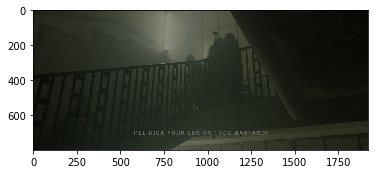

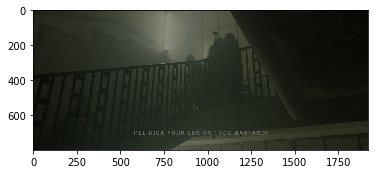

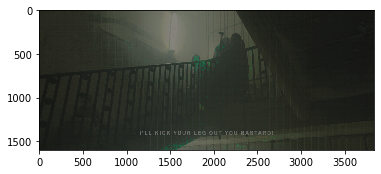

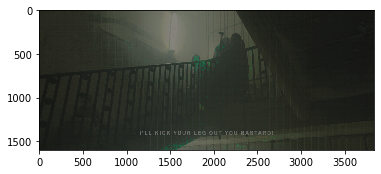

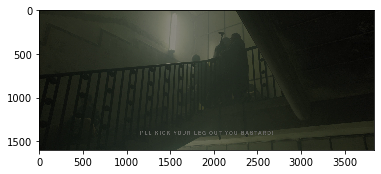

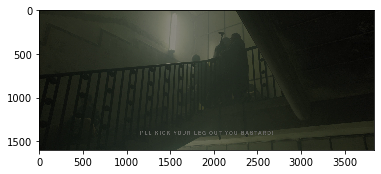

In [157]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, checkpoint_prefix)
    inputlow = np.asarray(reslo)
    lowInpImage = buildLargeImage(inputlow, 48,20)
    cv2.imwrite("generatedImages/2lo.jpg", lowInpImage );
    plt.imshow(lowInpImage)
    plt.show()    
    inputlow = inputlow /127.5 - 1.0

    gen_imgs= superz.predict(inputlow)
    gen_imgs = 0.5 * gen_imgs + 0.5
    resultImage = buildLargeImage(gen_imgs, 48,20)
    resultImage = (resultImage) *255 
    resultImage = resultImage.astype(int)
    plt.imshow(resultImage)
    plt.show()    
    cv2.imwrite("generatedImages/2.jpg", resultImage );
    
    resultHiImage = buildLargeImage(reshi, 48,20)
    plt.imshow(resultHiImage)
    plt.show()
    cv2.imwrite("generatedImages/2hi.jpg", resultHiImage );


